In [1]:
from preprocess import *
from DANN_CNN import *
import torch
import torch.nn as nn
import math
from torch.autograd import Function

data_list = load_data()

In [2]:
print(data_list[0][0][0])

[[28.64711257 25.25576416 22.28719729 20.03149889 18.97884146]
 [28.47546568 25.1305432  22.14369085 19.94620969 18.92574718]
 [28.46166623 25.08074815 22.17915738 20.79150425 20.40410457]
 [27.31460537 24.03644497 21.50020013 19.54308847 18.17308696]
 [27.06752403 23.7553792  21.48943708 20.26861039 19.52435963]
 [28.49581397 25.52772149 24.20379328 23.41705826 23.17346732]
 [27.01820175 23.68110662 21.50176775 20.08012914 19.2126027 ]
 [26.0479218  22.86857936 20.89454359 19.4465266  18.05282553]
 [25.55047388 22.49262691 20.73304001 19.22232904 17.7247097 ]
 [25.22744194 22.12862485 20.49071424 18.87011386 17.20306789]
 [24.97699416 21.84724292 20.27079737 18.82165424 17.55468221]
 [25.35239503 22.02870223 20.47512015 19.32675845 18.49596956]
 [26.27351593 22.79829787 21.16629349 20.35243541 19.89905989]
 [27.04623555 23.40303206 21.74259811 21.40196612 21.25597593]
 [27.34462238 23.72652198 21.83915755 20.6877083  20.3734425 ]
 [26.26827441 22.91551105 21.06503127 19.85238121 19.21

In [2]:
X_all = []
Y_class = []
Y_domain = []

for i in range(12):
    [X, Y] = data_list[i]
    X = get_CNN_data(X)
    X_all.append(X)
    Y_class.append(Y)
    Y_domain.append(np.full(X.shape[0], i))

X_all = np.concatenate(X_all)
Y_class = np.concatenate(Y_class)
Y_domain = np.concatenate(Y_domain)
assert(X_all.shape[0] == Y_domain.shape[0])

In [3]:
def dann_lambda(epoch, max_epoch, max_lambda=0.5):
    p = epoch / max_epoch

    lam = 2.0 / (1.0 + math.exp(-10 * p)) - 1.0
    lam = lam * max_lambda

    # if epoch < 2:
    #     lam = 0.0

    return lam


batch_size = 32
lr = 1e-4
epochs = 20
patience = 5

acc_list = []
acc_list_1 = []

for i in [2]:
# for i in range(12):
    print(f"This is person {i}")

    model = DANN(num_classes=3, num_domains=12).cuda()
    criterion_class = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_domain = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    mask1 = Y_domain != i
    mask2 = Y_domain == i

    X_train = X_all[mask1]
    Y_class_train = Y_class[mask1]
    Y_domain_train = Y_domain[mask1]

    X_test = X_all[mask2]
    Y_class_test = Y_class[mask2]
    Y_domain_test = Y_domain[mask2]
    
    train_dataset = DANNDataset(X_train, Y_class_train, Y_domain_train)
    test_dataset = DANNDataset(X_test, Y_class_test, Y_domain_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_acc_list = []
    domain_acc_list = []
    test_acc_list = []

    
    best_test_acc = 0
    bad_epochs = 0

    for epoch in range(epochs):
        p = float(epoch) / epochs
        lambd = dann_lambda(epoch, epochs)
        model.train()

        correct_train = 0
        correct_test = 0        

        for x, y_c, y_d in train_loader:

            x, y_c, y_d = x.cuda(), y_c.cuda(), y_d.cuda()

            optimizer.zero_grad()

            class_out, domain_out = model(x, lambd)
            loss_c = criterion_class(class_out, y_c)

            loss = loss_c
            loss.backward()
            optimizer.step()

            pred = class_out.argmax(dim=1)
            correct_train += (pred == y_c).sum().item()

        model.eval()

        with torch.no_grad():
            for x, y, _ in test_loader:
                x, y = x.cuda(), y.cuda()
                class_out, _ = model(x)
                loss = criterion_class(class_out, y)

                pred = class_out.argmax(dim=1)
                correct_test += (pred == y).sum().item()

        train_acc = correct_train / len(train_dataset)
        test_acc = correct_test / len(test_dataset)
        print(f"epoch {epoch+1}: train_acc = {train_acc}, test_acc = {test_acc}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            bad_epochs = 0
            best_weights = model.state_dict()
        # else:
        #     bad_epochs += 1
        #     if bad_epochs >= patience:
        #         print("Early stopping!")
        #         break
    
    acc_list.append(best_test_acc)
    acc_list_1.append(test_acc)
    

This is person 2
epoch 1: train_acc = 0.6764917584395019, test_acc = 0.7418844022169437
epoch 2: train_acc = 0.8500683797595912, test_acc = 0.6991290577988916
epoch 3: train_acc = 0.9195638091125027, test_acc = 0.55027711797308
epoch 4: train_acc = 0.9513064133016627, test_acc = 0.6239113222486145
epoch 5: train_acc = 0.9723961707334629, test_acc = 0.6706254948535234
epoch 6: train_acc = 0.9835888576981213, test_acc = 0.7652414885193982
epoch 7: train_acc = 0.9874757071906716, test_acc = 0.6888361045130641
epoch 8: train_acc = 0.9933419707766501, test_acc = 0.6278701504354711
epoch 9: train_acc = 0.9945656085798603, test_acc = 0.8103721298495645
epoch 10: train_acc = 0.9963650759375225, test_acc = 0.8155186064924782
epoch 11: train_acc = 0.9950334700928525, test_acc = 0.5558194774346793
epoch 12: train_acc = 0.996293097243216, test_acc = 0.6298495645288994
epoch 13: train_acc = 0.994349672496941, test_acc = 0.8087885985748219
epoch 14: train_acc = 0.9973727776578133, test_acc = 0.80720

In [4]:
torch.save(best_weights, "best_dann_no_domain_weights.pth")

[0.4770387965162312, 0.7731591448931117, 0.7347585114806018, 0.6270783847980997, 0.6326207442596992, 0.722486144101346, 0.5997624703087886, 0.5740300870942201, 0.6464766429136976, 0.61243072050673, 0.6175771971496437, 0.7216943784639747]
LOSO Mean Accuracy: 0.6449, Std: 0.0785


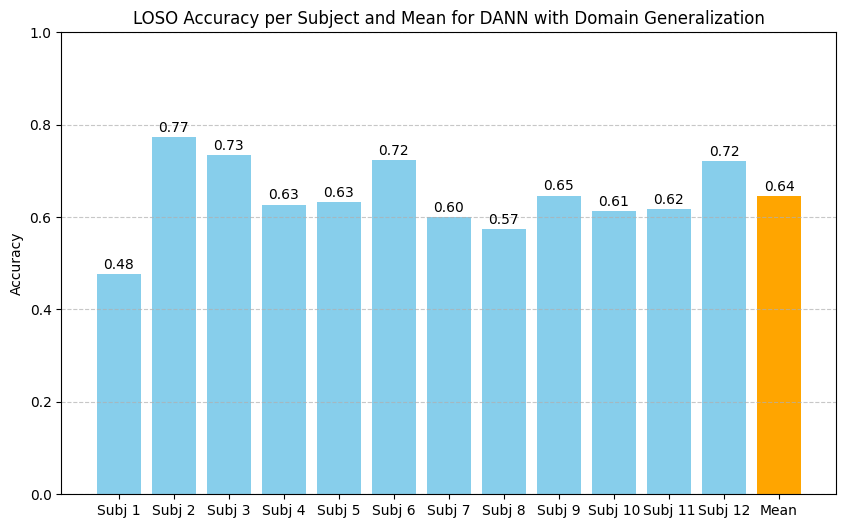

In [5]:
print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for DANN with Domain Generalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

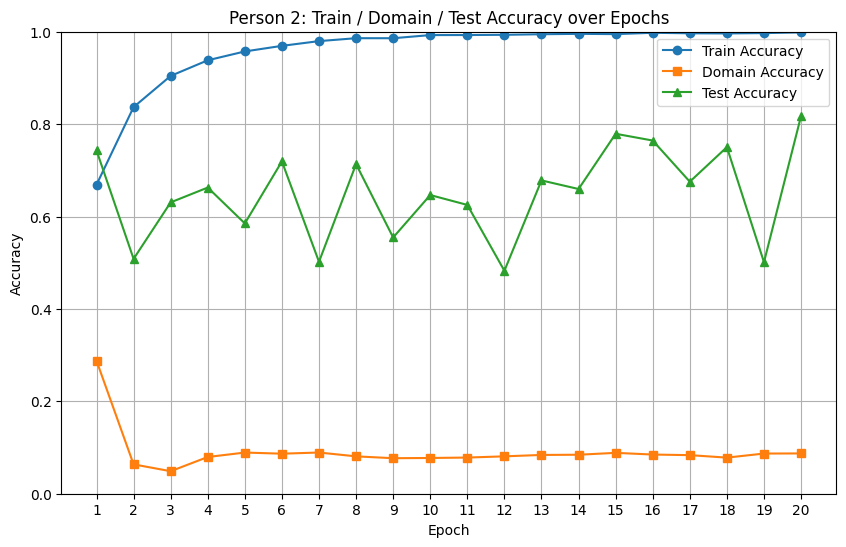

In [ ]:
import matplotlib.pyplot as plt

# Person 2 的数据
train_acc = [0.6687540488015548, 0.8368243000071979, 0.9043763046138343, 0.9382062909378824,
             0.9573166342762542, 0.9694090549197437, 0.9796660188584179, 0.9860001439573887,
             0.9859281652630821, 0.9926941625278918, 0.9928381199165047, 0.9933059814294969,
             0.9945656085798603, 0.9953933635643849, 0.9948175340099331, 0.9976966817821925,
             0.9965810120204419, 0.996293097243216, 0.9970128841862809, 0.9985964154610235]

test_acc = [0.7430720506730008, 0.5083135391923991, 0.6306413301662708, 0.66270783847981,
            0.5851148060174188, 0.7193190815518606, 0.5019794140934284, 0.7133808392715756,
            0.5546318289786223, 0.6464766429136976, 0.6250989707046715, 0.4825811559778306,
            0.6781472684085511, 0.6595407759303247, 0.7790973871733967, 0.764449722882027,
            0.6753760886777513, 0.7501979414093428, 0.501187648456057, 0.8174980205859066]

# 构建 x 轴：1-base epoch
epochs = list(range(1, 21))  # 1,2,...20

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='^', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Person 2: Train / Test Accuracy over Epochs')
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()
